In [ ]:
def add_stdpert(df, dirs):
    ''' Find stdev map files '''

    map_list = []
    for d in dirs:
        d = os.path.abspath(TESTDIR+'/'+d)
        map_list += [os.path.join(d,file) for file in os.listdir(d) if file == 'map_files.txt']

    ''' Make a stdev column '''

    df = pd.read_csv(FILENAME, skipinitialspace=True)
    df['stdev'] = pd.Series(np.zeros(len(df['structure'])), index=df.index)

    for file in map_list:
        method = file.split('/')[-2]
        for line in open(file,'r'):
            if 'rattled' in line:
                stdev = float(line.split(':')[-2].split('/')[-2][3:]) # st. dev. on left part
                struct = line.split(':')[-1].split('/')[-1].lstrip(' ').rstrip('\n') # folder and struct on right part
                mask = (df['method'] == method) & (df['structure'] == struct) & (df['folder'] == 'rattled') # find right structure
                df.loc[mask,'stdev'] = stdev
    return df

def autolabel(rects):
	for rect in rects:
		height = rect.get_height()
		ax.annotate('{}'.format(height),
					xy=(rect.get_x() + rect.get_width() / 2, height),
					xytext=(0, 3),  # 3 points vertical offset
					textcoords="offset points",
					ha='center', va='bottom')
        
def OptSucc(df):
    ''' No. of optimised structures per method (diff no. of total structures) '''
    ''' Normalised to per cent '''

    ran_succ_list = []
    rat_succ_list = []
    totals = {}

    labels = list(df['method'].unique())
    dicts = {}
    
    # For each method and each case
    for method in labels:
        random = df[df['folder'] == 'random']
        random = random.loc[random['method'] == method]

        rattled = df[df['folder'] == 'rattled']
        rattled = rattled.loc[rattled['method'] == method]
        
        # Find successful structs
        ran_succ = len([b for b in random['opt_succ'] if b])
        rat_succ = len([b for b in rattled['opt_succ'] if b])

        #         ran_succ = len(random.loc[random['opt_succ'] == True].index)
#         rat_succ = len(rattled.loc[rattled['opt_succ'] == True].index)

        ran_perc = 0
        if len(random):
            ran_perc = round(ran_succ*100/len(random),2)
        rat_perc = 0
        if len(rattled):
            rat_perc = round(rat_succ*100/len(rattled),2)

        ran_succ_list.append(ran_perc)
        rat_succ_list.append(rat_perc)

    ''' Plot '''

    y = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,15))
    ax.grid(zorder=0)
    rects1 = ax.barh(y - width/2, ran_succ_list, width, zorder=3, label='Random') # x% per init category
    rects2 = ax.barh(y + width/2, rat_succ_list, width, zorder=3, label='Rattled')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    for i, v in enumerate(ran_succ_list):
        ax.text(v + 1, i - width/2, str(v), fontsize=15)

    for i, v in enumerate(rat_succ_list):
        ax.text(v + 1, i + width/2, str(v), fontsize=15)

    ax.set_xlim(0,110)
    ax.set_yticks(y)
    ax.tick_params(labelsize=15)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.legend(fontsize=15)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Successfully Optimised Structures', fontsize=20)

    plt.savefig(PLOTDIR+'/'+'OptSucc', format=FORMAT)
    plt.show()
    

    
def TimeDev(df):
    ''' Variation of Optimisation time '''

    methods = list(df['method'].unique())
    total_succ = df[df['opt_succ'] == True] # times of successful opt/ions
    total_succ = total_succ[['method','opt_time']]

    # successful optimisations per case
    ran_succ = df[df['folder'] == 'random']
    ran_succ = ran_succ.loc[ran_succ['opt_succ'] == True][['method','opt_time']] 
    
    rat_succ = df[df['folder'] == 'rattled']
    rat_succ = rat_succ.loc[rat_succ['opt_succ'] == True][['method','opt_time']]

    # Total
    means = total_succ.groupby(['method']).mean()
    stdevs = total_succ.groupby(['method']).apply(np.std)

    ms = means.join(stdevs, lsuffix='_m', rsuffix='_std')

    # Random
    ran_means = ran_succ.groupby(['method']).mean()
    ran_stdevs = ran_succ.groupby(['method']).apply(np.std)

    ran_ms = ran_means.join(ran_stdevs, lsuffix='_m', rsuffix='_std')
    ms_all = ms.join(ran_ms, rsuffix='_ran')

    # Rattled
    rat_means = rat_succ.groupby(['method']).mean()
    rat_stdevs = rat_succ.groupby(['method']).apply(np.std)

    rat_ms = rat_means.join(rat_stdevs, lsuffix='_m', rsuffix='_std')
    ms_all = ms_all.join(rat_ms, rsuffix='_rat')

    fig, ax = plt.subplots(figsize=(15,15))

    ind = np.arange(len(methods))  # the x locations for the groups
    width = 0.3  # the width of the bars

    ax.grid(zorder=0)
    ax.errorbar(ind - width/3, ms_all['opt_time_m_ran'], ms_all['opt_time_std_ran'], 
                linestyle='None', marker='o', ecolor='red',mfc='red',
                zorder=3, mec='red', label='random')
    ax.errorbar(ind, ms_all['opt_time_m'], ms_all['opt_time_std'], linestyle='None', 
                marker='o', ecolor='blue', mfc='blue',
                zorder=3, mec='blue', label='all')
    ax.errorbar(ind + width/3, ms_all['opt_time_m_rat'], ms_all['opt_time_std_rat'], 
                linestyle='None', marker='o', ecolor='orange', mfc='orange',
                zorder=3, mec='orange', label='rattled')

    ax.set_xticks(ind)
    ax.set_xticklabels([row for row in ms_all.index])
    ax.tick_params(labelsize=15)
    ax.set_ylabel('Time (sec)', fontsize=15)
    ax.legend(fontsize=15)
    start, end = ax.get_ylim()
    ax.set_yticks(np.arange(start, end, 0.5))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Optimisation Time Deviation', x=0.524, fontsize=20)

    plt.savefig(PLOTDIR+'/'+'TimeDev', format=FORMAT)
    plt.show()

def MeanEnergyIterI(df, dfe):
    ''' Mean of energy value per iteration '''

    # %pylab
    methods = list(df['method'].unique()) # list of methods
    fig, axs = plt.subplots(3, 1, figsize=(15,15))

    # Random 
    random = df[df['folder'] == 'random']

    xticks = 0
    for method in methods: # for each method 

        ran_m = random.loc[(random['method'] == method)][['structure', # keep random cases
                                                       'opt_succ']].set_index('structure')
        mask = (dfe['method'] == method) & (dfe['folder'] == 'random') # fit method and keep random
                                                                       # from energy iters file
        dfe_m = dfe[mask] # results for this method
        dfe_m = dfe_m.set_index('structure')
        e_res = dfe_m.join(ran_m, on='structure') # join on each struct

        # find successful cases
        e_succ = e_res.loc[e_res['opt_succ'] == True]
        e_succ = e_succ.drop(['opt_succ'], axis=1)
        mean = e_succ.groupby(['method']).mean().T # mean of each iteration in one column
        mean.columns = ['energy']
        
        axs[0].plot(mean['energy'], label=method)
        axs[0].legend()
        lmean = len(mean.dropna())
        xticks = lmean if lmean > xticks else xticks

        # find failed cases
        e_fail = e_res.loc[e_res['opt_succ'] == False]
        e_fail = e_fail.drop(['opt_succ'], axis=1)
        mean = e_fail.groupby(['method']).mean().T # mean of each iteration in one column
        mean.columns = ['energy']

        axs[1].plot(mean['energy'], label=method)
        axs[1].legend()

    axs[0].grid()
    axs[0].set_title('Successful Random')
    axs[0].set_xlim(0, xticks+5)
    axs[0].set_xticks(np.arange(0, xticks+5, 25))
    starty, endy = axs[0].get_ylim()

    axs[1].grid()
    axs[1].set_xlim(0, xticks+5)
    axs[1].set_xticks(np.arange(0, xticks+5, 25))
    axs[1].set_title('Failed Random')


    # Rattled
    rattled = df[df['folder'] == 'rattled']

    xticks = 0
    for method in methods: # for each method keep structures from both dfs

        rat_m = rattled.loc[(rattled['method'] == method)][['structure', # keep rattled cases
                                                       'opt_succ']].set_index('structure')
        mask = (dfe['method'] == method) & (dfe['folder'] == 'rattled') # fit method and keep rattled
                                                                       # from energy iters file
        dfe_m = dfe[mask] # results for this method 
        dfe_m.set_index('structure')
        e_res = dfe_m.join(rat_m, on='structure') # join on each struct

        # find successful cases
        e_succ = e_res.loc[e_res['opt_succ'] == True]
        e_succ = e_succ.drop(['opt_succ'], axis=1)
        mean = e_succ.groupby(['method']).mean().T # mean of each iteration in one column
        mean.columns = ['energy']

        axs[2].plot(mean['energy'], label=method)
        axs[2].legend()
        lmean = len(mean.dropna())
        xticks = lmean if lmean > xticks else xticks

    axs[2].grid()
    axs[2].set_title('Rattled')
    axs[2].set_xlim(0, xticks+5)
    axs[2].set_xticks(np.arange(0, xticks+5, 5))

    fig.text(-0.05, 1.7, 'Energy (eV)', horizontalalignment='center',
          verticalalignment='center',rotation=90, transform=plt.gca().transAxes)
    fig.text(0.5, -0.15, 'Steps', horizontalalignment='center',
          verticalalignment='center', transform=plt.gca().transAxes)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Mean Energy Value per Iteration', x=0.524, fontsize=20)

#     plt.savefig(PLOTDIR+'/'+'MeanEnergyIterI', format=FORMAT)
    plt.show()

    
def MeanGnormIterI(df, dfg):
    ''' Mean of gnorm value per iteration '''
    # %pylab

    methods = list(df['method'].unique()) # list of methods
    xticks = 0
    fig, axs = plt.subplots(3, 1, figsize=(15,15))

    # Random 
    random = df[df['folder'] == 'random']

    xticks = 0
    for method in methods: # for each method keep structures from both dfs

        ran_m = random.loc[(random['method'] == method)][['structure',
                                                       'opt_succ']].set_index('structure')
        mask = (dfe['method'] == method) & (dfe['folder'] == 'random') # fit method and keep random
                                                                       # from energy iters file
        dfg_m = dfg[mask] # results for this method 
        dfg_m = dfg_m.set_index('structure')
        e_res = dfg_m.join(ran_m, on='structure') # join on each struct

        # find successful cases
        e_succ = e_res.loc[e_res['opt_succ'] == True]
        e_succ = e_succ.drop(['opt_succ'], axis=1)
        mean = e_succ.groupby(['method']).mean().T # mean of each iteration in one column
        mean.columns = ['energy']

        axs[0].plot(mean['energy'], label=method)
        axs[0].legend()
        lmean = len(mean.dropna())
        xticks = lmean if lmean > xticks else xticks

        # find failed cases
        e_fail = e_res.loc[e_res['opt_succ'] == False]
        e_fail = e_fail.drop(['opt_succ'], axis=1)
        mean = e_fail.groupby(['method']).mean().T # mean of each iteration in one column
        mean.columns = ['energy']

        axs[1].plot(mean['energy'], label=method)
        axs[1].legend()

    axs[0].grid()
    axs[0].set_title('Successful Random')
    # axs[0].set_ylim(starty, -300)
    axs[0].set_xlim(0, xticks+5)
    axs[0].set_xticks(np.arange(0, xticks+5, 25))
    starty, endy = axs[0].get_ylim()

    axs[1].grid()
    axs[1].set_xlim(0, xticks+5)
    axs[1].set_xticks(np.arange(0, xticks+5, 25))
    # axs[1].set_ylim(starty, endy)
    axs[1].set_title('Failed Random')
    # axs[1].ticklabel_format(style='plain', axis='y', scilimits=(0,0))


    # Rattled
    rattled = df[df['folder'] == 'rattled']

    xticks = 0
    for method in methods: # for each method keep structures from both dfs

        rat_m = rattled.loc[(rattled['method'] == method)][['structure',
                                                       'opt_succ']].set_index('structure')
        mask = (dfg['method'] == method) & (dfg['folder'] == 'rattled') # fit method and keep rattled
                                                                               # from energy iters file
        dfg_m = dfg[mask] # results for this method 
        dfg_m.set_index('structure')
        e_res = dfg_m.join(rat_m, on='structure') # join on each struct

        # find successful cases
        e_succ = e_res.loc[e_res['opt_succ'] == True]
        e_succ = e_succ.drop(['opt_succ'], axis=1)
        mean = e_succ.groupby(['method']).mean().T # mean of each iteration in one column
        mean.columns = ['energy']

        axs[2].plot(mean['energy'], label=method)
        axs[2].legend()
        lmean = len(mean.dropna())
        xticks = lmean if lmean > xticks else xticks

    axs[2].grid()
    axs[2].set_title('Rattled')
    axs[2].set_xlim(0, xticks+5)
    axs[2].set_xticks(np.arange(0, xticks+5, 25))
    starty, endy = axs[2].get_ylim()

    fig.text(-0.1, 1.7, 'Gnorm', horizontalalignment='center',
          verticalalignment='center',rotation=90, transform=plt.gca().transAxes)
    fig.text(0.5, -0.15, 'Steps', horizontalalignment='center',
          verticalalignment='center', transform=plt.gca().transAxes)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Mean Gnorm Value per Iteration', x=0.524, fontsize=20)

    plt.savefig(PLOTDIR+'/'+'MeanGnormIterI', format=FORMAT)
    plt.show()

def OptTime(df):
    ''' Optimisation time per method '''
    
    FONTSIZE = 12
    
    df = add_stdpert(df, dirs) # add stdev to dataframe
    methods = list(df['method'].unique())
    maps = list(df['method'])
    ran_succ = df[df['folder'] == 'random']
    ran_succ = ran_succ.loc[ran_succ['opt_succ'] == True] # find successful optimisations

    rat_succ = df[df['folder'] == 'rattled']
    rat_succ = rat_succ.loc[rat_succ['opt_succ'] == True] 


    fig, axs = plt.subplots(2,figsize=(15,15))
    colors = {'red' : methods[0], 
              'orange' : methods[1], 
              'green' : methods[2], 
              'purple' : methods[3]}

    clabels = ['red', 'orange', 'green', 'purple']

    # Random

    axs[0].grid(zorder=0)
    for color in clabels:
        x = ran_succ.loc[ran_succ['method'] == colors[color]]['structure']
        y = ran_succ.loc[ran_succ['method'] == colors[color]]['opt_time']
        axs[0].scatter(x, y, c='tab:'+color, label=colors[color],
                   zorder=3, alpha=0.7)

    # Rattled  

    axs[1].grid(zorder=0)
    slabels = []
    for color in clabels:
        x = rat_succ.loc[rat_succ['method'] == colors[color]]['structure']
        y = rat_succ.loc[rat_succ['method'] == colors[color]]['opt_time']
        sizes = rat_succ.loc[rat_succ['method'] == colors[color]]['stdev']
        slabels += [s for s in sizes.unique() if s not in slabels]
        scatter = axs[1].scatter(x, y, s=sizes*1000, c='tab:'+color,
                                zorder=3, alpha=0.7)

    start0, end0 = axs[0].get_ylim()
    start1, end1 = axs[1].get_ylim()    

    end = max(end0, end1)+1

    axs[0].legend(loc="upper left")
    axs[0].set_xticks([])
    axs[0].set_xlabel('Optimised Structures')
    axs[0].set_ylabel('Time (sec)')
    axs[0].yaxis.set_ticks(np.arange(0, end))
    axs[0].set_title('Random Initialisation', fontsize=FONTSIZE)

    h = [plt.scatter([],[], s=i*1000, c="gray") for i in slabels]
    leg = plt.legend(handles=h, labels=slabels,loc="upper right", title="Standard Deviation")
    axs[1].add_artist(leg)

    h = [plt.plot([],[], color='tab:'+c, alpha=0.7, marker="o", ls="")[0] for c in colors]
    leg = plt.legend(handles=h, labels=[colors[c] for c in colors],loc="upper left")
    axs[1].add_artist(leg)

    axs[1].set_xlabel('Optimised Structures')
    axs[1].set_ylabel('Time (sec)')
    axs[1].yaxis.set_ticks(np.arange(0, end))
    axs[1].set_title('Rattled Initialisation', fontsize=FONTSIZE)
    axs[1].set_xticks([])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Optimisation Time',x=0.51, fontsize=20)

    plt.savefig(PLOTDIR+'/'+'OptTime', format=FORMAT)
    plt.show()

def OptEnergy(df):
    ''' Optimised energy  '''

    FONTSIZE = 12

    df = add_stdpert(df, dirs) # add stdev to dataframe
    methods = list(df['method'].unique())
    maps = list(df['method'])
    ran_succ = df[df['folder'] == 'random']
    ran_succ = ran_succ.loc[ran_succ['opt_succ'] == True] # find successful optimisations

    rat_succ = df[df['folder'] == 'rattled']
    rat_succ = rat_succ.loc[rat_succ['opt_succ'] == True] 

    fig, axs = plt.subplots(2,figsize=(15,15))
    colors = {'red' : methods[0], 
              'orange' : methods[1], 
              'green' : methods[2], 
              'purple' : methods[3]}

    clabels = ['red', 'orange', 'green', 'purple']

    # Random

    axs[0].grid(zorder=0)
    for color in clabels:
        x = ran_succ.loc[ran_succ['method'] == colors[color]]['structure']
        y = ran_succ.loc[ran_succ['method'] == colors[color]]['energy']
        axs[0].scatter(x, y, c='tab:'+color, label=colors[color],
                   zorder=3, alpha=0.7)

    # Rattled    

    slabels = []
    axs[1].grid(zorder=0)
    for color in clabels:
        x = rat_succ.loc[rat_succ['method'] == colors[color]]['structure']
        y = rat_succ.loc[rat_succ['method'] == colors[color]]['energy']
        sizes = rat_succ.loc[rat_succ['method'] == colors[color]]['stdev']
        slabels += [s for s in sizes.unique() if s not in slabels]
        scatter = axs[1].scatter(x, y, s=sizes*1000, c='tab:'+color,
                                zorder=3, alpha=0.7)

    start0, end0 = axs[0].get_ylim()
    start1, end1 = axs[1].get_ylim()    

    start = min(start0, start1)
    end = max(end0, end1)+1

    axs[0].legend(loc="upper left")
    axs[0].set_xticks([])
    axs[0].set_xlabel('Optimised Structures')
    axs[0].set_ylabel('Energy')
    axs[0].yaxis.set_ticks(np.arange(start, end))
    axs[0].set_title('Random Initialisation', fontsize=FONTSIZE)

    h = [plt.scatter([],[], s=i*1000, c="gray") for i in slabels]
    leg = plt.legend(handles=h, labels=slabels,loc="upper right", title="Standard Deviation")
    axs[1].add_artist(leg)

    h = [plt.plot([],[], color='tab:'+c, alpha=0.7, marker="o", ls="")[0] for c in colors]
    leg = plt.legend(handles=h, labels=[colors[c] for c in colors],loc="upper left")
    axs[1].add_artist(leg)

    axs[1].set_xlabel('Optimised Structures')
    axs[1].set_ylabel('Energy')
    axs[1].yaxis.set_ticks(np.arange(start, end))
    axs[1].set_title('Rattled Initialisation', fontsize=FONTSIZE)
    axs[1].set_xticks([])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Optimisation Final Energy',x=0.53, fontsize=20)

    plt.savefig(PLOTDIR+'/'+'OptEnergy', format=FORMAT)
    plt.show()

def InitFinalE(df, dfe):
    ''' Initial vs final energy '''

    methods = list(df['method'].unique()) # list of methods
    fig, axs = plt.subplots(3, 1, figsize=(15,15))

    # Random
    random = df[df['folder'] == 'random']
    for method in methods: # for each method keep structures from both dfs
        x,y = [],[]

        total_m = random.loc[(random['method'] == method)][['structure',
                                                       'opt_succ']].set_index('structure')
        mask = (dfe['method'] == method) & (dfe['folder'] == 'random') # fit method and keep random
                                                                           # from energy iters file
        dfe_m = dfe[mask] # results for this method  
        dfe_m.set_index('structure')
        e_res = dfe_m.join(total_m, on='structure') # join on each struct
        e_res.to_csv('CHECK.csv')  #############################################TEST

        # find successful cases
        e_succ = e_res.loc[e_res['opt_succ'] == True]
        e_succ = e_succ.drop(['opt_succ'], axis=1)
        for index,row in e_succ.iterrows():
            row = row.dropna() # drop NaN values
            values = row[3:-1]
            x.append(values[0]) # initial energy
            y.append(values[-1]) # final energy
        axs[0].scatter(x, y, label=method)
        axs[0].legend()

        x,y = [],[]

        # find failed cases
        e_fail = e_res.loc[e_res['opt_succ'] == False]
        e_fail = e_fail.drop(['opt_succ'], axis=1)
        for index,row in e_fail.iterrows():
            row = row.dropna() # drop NaN values
            values = row[3:-1]
            x.append(values[0]) # initial energy
            y.append(values[-1]) # final energy
        axs[1].scatter(x, y, label=method)
        axs[1].legend()

    axs[0].grid()
    axs[0].set_title('Successful Random')
    axs[0].set(ylabel='Energy (eV)')

    axs[1].grid()
    axs[1].set_title('Failed Random')
    axs[1].ticklabel_format(style='plain', axis='y', scilimits=(0,0))
    axs[1].set(xlabel='Energy (eV)', ylabel='Energy (eV)')

    # Rattled
    rattled = df[df['folder'] == 'rattled']
    for method in methods: # for each method keep structures from both dfs
        x,y = [],[]

        total_m = rattled.loc[(rattled['method'] == method)][['structure',
                                                       'opt_succ']].set_index('structure')
        mask = (dfe['method'] == method) & (dfe['folder'] == 'rattled') # fit method and keep random
                                                                           # from energy iters file
        dfe_m = dfe[mask] # results for this method  
        dfe_m.set_index('structure')
        e_res = dfe_m.join(total_m, on='structure') # join on each struct

        # find successful cases
        e_succ = e_res.loc[e_res['opt_succ'] == True]
        e_succ = e_succ.drop(['opt_succ'], axis=1)
        for index,row in e_succ.iterrows():
            row = row.dropna() # drop NaN values
            values = row[3:-1]
            x.append(values[0]) # initial energy
            y.append(values[-1]) # final energy
        axs[2].scatter(x, y, label=method)
        axs[2].legend()

        x,y = [],[]
        
        
    axs[2].grid()
    axs[2].set_title('Rattled')
    axs[2].set(ylabel='Energy (eV)')
        
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Initial vs Final energy',x=0.54, fontsize=20)
    plt.savefig(PLOTDIR+'/'+'InitFinalE', format=FORMAT)
    plt.show()

def CyclesSw(df):
    ''' Cycles to switch (both succ and not) '''

    df_s = df.loc[df['method']=='switch']
    random = df_s[df_s['folder'] == 'random']
    rattled = df_s[df_s['folder'] == 'rattled']

    fig, axs = plt.subplots(2,figsize=(15,15))

    ind0 = np.arange(len(random))    # the x locations for the groups
    ind1 = np.arange(len(rattled))


    # Random

    axs[0].grid(zorder=0)
    count = 0
    for index,row in random.iterrows():         
        if row['switch'] > 0: # managed to switch
            if row['opt_succ'] == True:
                p1 = axs[0].bar(ind0[count], row['switch'], color='green', 
                           zorder=3, alpha=0.5) # successful
            else:
                p1b = axs[0].bar(ind0[count], row['switch'], color='red',
                               zorder=3, alpha=0.5) 
            p2 = axs[0].bar(ind0[count], row['cycles']-row['switch'], # cycles after switch
                             bottom=row['switch'], color='blue',
                                zorder=3)
        else: # never switched algorithm
            if row['opt_succ'] == True:
                p1 = axs[0].bar(ind0[count], row['cycles'], color='green', 
                           zorder=3, alpha=0.5) # successful
            else:
                p1b = axs[0].bar(ind0[count], row['cycles'], color='red',
                               zorder=3, alpha=0.5)
        count += 1

    axs[0].set_title('Random')
    axs[0].set_xticks([])

    p1b = None
    if p1b:
        axs[0].legend((p1[0], p1b[0], p2[0]), ('Successful', 'Failed', 'After Switch'))


    # Rattled

    diff = rattled['cycles']-rattled['switch'] # cycles after switch

    axs[1].grid(zorder=0)
    count = 0
    for index,row in rattled.iterrows():
        if row['switch'] > 0: # managed to switch
            if row['opt_succ'] == True:
                p1 = axs[1].bar(ind1[count], row['switch'], color='green', 
                           zorder=3, alpha=0.5) # successful
            else:
                p1b = axs[1].bar(ind1[count], row['switch'], color='red',
                               zorder=3, alpha=0.5) 
            p2 = axs[1].bar(ind1[count], row['cycles']-row['switch'], # cycles after switch
                             bottom=row['switch'], color='blue',
                                zorder=3)
        else: # never switched algorithm
            if row['opt_succ'] == True:
                p1 = axs[1].bar(ind1[count], row['cycles'], color='green', 
                           zorder=3, alpha=0.5) # successful
            else:
                p1b = axs[1].bar(ind1[count], row['cycles'], color='red',
                               zorder=3, alpha=0.5)
        count += 1

    start0, end0 = axs[0].get_ylim()
    start1, end1 = axs[1].get_ylim()    

    start = min(start0, start1)
    end = max(end0, end1)+1
    stepsize = 50
    axs[0].yaxis.set_ticks(np.arange(start, end, stepsize))
    axs[1].yaxis.set_ticks(np.arange(start, end, stepsize))

    axs[1].set_title('Rattled')
    axs[1].set_xticks([])

    if p1b:
        axs[1].legend((p1[0], p1b[0], p2[0]), ('Successful', 'Failed', 'After Switch'))

    fig.text(-0.05, 1, 'Cycle Number', horizontalalignment='center',
          verticalalignment='center',rotation=90, transform=plt.gca().transAxes)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Cycles to Switch', x=0.52, fontsize=20)

    plt.savefig(PLOTDIR+'/'+'CyclesSw', format=FORMAT)
    plt.show()

def CyclesSw_o(df):
    ''' Cycles to switch (both succ and not) '''
    ''' with change to stepsize '''

    df_s = df.loc[df['method']=='switch_o']
    random = df_s[df_s['folder'] == 'random']
    rattled = df_s[df_s['folder'] == 'rattled']

    fig, axs = plt.subplots(2,figsize=(15,15))

    ind0 = np.arange(len(random))    # the x locations for the groups
    ind1 = np.arange(len(rattled))


    # Random

    axs[0].grid(zorder=0)
    count = 0
    for index,row in random.iterrows():         
        if row['switch'] > 0: # managed to switch
            if row['opt_succ'] == True:
                p1 = axs[0].bar(ind0[count], row['switch'], color='green', 
                           zorder=3, alpha=0.5) # successful
            else:
                p1b = axs[0].bar(ind0[count], row['switch'], color='red',
                               zorder=3, alpha=0.5) 
            p2 = axs[0].bar(ind0[count], row['cycles']-row['switch'], # cycles after switch
                             bottom=row['switch'], color='blue',
                                zorder=3)
        else: # never switched algorithm
            if row['opt_succ'] == True:
                p1 = axs[0].bar(ind0[count], row['cycles'], color='green', 
                           zorder=3, alpha=0.5) # successful
            else:
                p1b = axs[0].bar(ind0[count], row['cycles'], color='red',
                               zorder=3, alpha=0.5)
        count += 1

    axs[0].set_title('Random')
    axs[0].set_xticks([])

    p1b = None
    if p1b:
        axs[0].legend((p1[0], p1b[0], p2[0]), ('Successful', 'Failed', 'After Switch'))


    # Rattled

    diff = rattled['cycles']-rattled['switch'] # cycles after switch

    axs[1].grid(zorder=0)
    count = 0
    for index,row in rattled.iterrows():
        if row['switch'] > 0: # managed to switch
            if row['opt_succ'] == True:
                p1 = axs[1].bar(ind1[count], row['switch'], color='green', 
                           zorder=3, alpha=0.5) # successful
            else:
                p1b = axs[1].bar(ind1[count], row['switch'], color='red',
                               zorder=3, alpha=0.5) 
            p2 = axs[1].bar(ind1[count], row['cycles']-row['switch'], # cycles after switch
                             bottom=row['switch'], color='blue',
                                zorder=3)
        else: # never switched algorithm
            if row['opt_succ'] == True:
                p1 = axs[1].bar(ind1[count], row['cycles'], color='green', 
                           zorder=3, alpha=0.5) # successful
            else:
                p1b = axs[1].bar(ind1[count], row['cycles'], color='red',
                               zorder=3, alpha=0.5)
        count += 1

    start0, end0 = axs[0].get_ylim()
    start1, end1 = axs[1].get_ylim()    

    start = min(start0, start1)
    end = max(end0, end1)+1
    stepsize = 50
    axs[0].yaxis.set_ticks(np.arange(start, end, stepsize))
    axs[1].yaxis.set_ticks(np.arange(start, end, stepsize))

    axs[1].set_title('Rattled')
    axs[1].set_xticks([])

    if p1b:
        axs[1].legend((p1[0], p1b[0], p2[0]), ('Successful', 'Failed', 'After Switch'))

    fig.text(-0.05, 1, 'Cycle Number', horizontalalignment='center',
          verticalalignment='center',rotation=90, transform=plt.gca().transAxes)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Cycles to Switch', x=0.52, fontsize=20)    

    plt.savefig(PLOTDIR+'/'+'CyclesSw_o', format=FORMAT)
    plt.show()
    
def CycleNo(df):
    ''' No. of  cycles'''
    ''' Successful optimisations '''

    methods = list(df['method'].unique())
    total_succ = df[df['opt_succ'] == True] # times of successful opt/ions
    total_succ = total_succ[['method','cycles']]

    # successful optimisations per case
    ran_succ = df[df['folder'] == 'random']
    ran_succ = ran_succ.loc[ran_succ['opt_succ'] == True][['method','cycles']]
    
    rat_succ = df[df['folder'] == 'rattled']
    rat_succ = rat_succ.loc[rat_succ['opt_succ'] == True][['method','cycles']]

    # Total
    means = total_succ.groupby(['method']).mean()
    stdevs = total_succ.groupby(['method']).apply(np.std)

    ms = means.join(stdevs, lsuffix='_m', rsuffix='_std')

    # Random
    ran_means = ran_succ.groupby(['method']).mean()
    ran_stdevs = ran_succ.groupby(['method']).apply(np.std)

    ran_ms = ran_means.join(ran_stdevs, lsuffix='_m', rsuffix='_std')
    ms_all = ms.join(ran_ms, rsuffix='_ran')

    # Rattled
    rat_means = rat_succ.groupby(['method']).mean()
    rat_stdevs = rat_succ.groupby(['method']).apply(np.std)

    rat_ms = rat_means.join(rat_stdevs, lsuffix='_m', rsuffix='_std')
    ms_all = ms_all.join(rat_ms, rsuffix='_rat')

    fig, ax = plt.subplots(figsize=(15,15))

    ind = np.arange(len(methods))  # the x locations for the groups
    width = 0.3  # the width of the bars

    ax.grid(zorder=0)
    ax.errorbar(ind - width/3, ms_all['cycles_m_ran'], ms_all['cycles_std_ran'], 
                linestyle='None', marker='o', ecolor='red',mfc='red',
                zorder=3, mec='red', label='random')
    ax.errorbar(ind, ms_all['cycles_m'], ms_all['cycles_std'], linestyle='None', 
                marker='o', ecolor='blue', mfc='blue',
                zorder=3, mec='blue', label='all')
    ax.errorbar(ind + width/3, ms_all['cycles_m_rat'], ms_all['cycles_std_rat'], 
                linestyle='None', marker='o', ecolor='orange', mfc='orange',
                zorder=3, mec='orange', label='rattled')

    ax.set_xticks(ind)
    ax.set_xticklabels([row for row in ms_all.index])
    ax.tick_params(labelsize=15)
    ax.set_ylabel('Cycles', fontsize=15)
    ax.legend(fontsize=15)
    start, end = ax.get_ylim()
    ax.set_yticks(np.arange(start, end, 15))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Optimisation Cycles', x=0.524, fontsize=20)

    plt.savefig(PLOTDIR+'/'+'CycleNo', format=FORMAT)
    plt.show()

In [ ]:
    
def BuckCat(df):
    ''' Measure frequency of Buckingham catastrophe '''
    
    fail_list = []
    methods = list(df['method'].unique()) # list of methods
    fig, ax = plt.subplots(figsize=(9,9))

    for method in methods: # for each method keep failed structures 
        x,y = [],[]

        total_m = df.loc[(df['method'] == method)][['structure', 'energy',
                                                       'opt_succ']]        
        # find failed cases with abs energy > 1000
        e_fail = total_m.loc[(total_m['opt_succ'] == False) & (abs(total_m['energy'])>500)]
        fail_list.append(round(len(e_fail)/len(total_m)*100,1))        

    ''' Plot '''

    y = np.arange(len(methods))  # the label locations
    width = 0.35  # the width of the bars

    ax.grid(zorder=0)
    rects = ax.barh(y - width/2, fail_list, width, zorder=3) # x% per init category

    # Add some text for labels, title and custom x-axis tick labels, etc.
    for i, v in enumerate(fail_list):
        ax.text(v + 1, i - width/2, str(v), fontsize=15)

    ax.set_xlim(0,110)
    ax.set_yticks(y)
    ax.tick_params(labelsize=15)
    ax.set_yticklabels(methods)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.legend(fontsize=15)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Percentage of failed cases with underflown energy', fontsize=20)

    plt.savefig(PLOTDIR+'/'+'BuckCat_500', format=FORMAT)
    plt.show()

In [ ]:
''' Regression '''

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%pylab

def cat_reg(folder, success, methods, axi):
    ''' Perform regression on selected type of data '''
    
    df_ = df[df['folder'] == folder]
    
    for method in methods: # for each method keep structures from both dfs
        total_m = df_.loc[(df_['method'] == method)][['structure',
                                                       'opt_succ']].set_index('structure')
        mask = (dfe['method'] == method) & (dfe['folder'] == folder) # fit method and keep random
                                                                           # from energy iters file
        dfe_m = dfe[mask] # results for this method  
        dfe_m.set_index('structure')
        e_res = dfe_m.join(total_m, on='structure') # join on each struct
        
        X, y = [],[]
        
        # find successful cases
        e_succ = e_res.loc[e_res['opt_succ'] == success]
        e_succ = e_succ.drop(['opt_succ'], axis=1)
        for index,row in e_succ.iterrows():
            row = row.dropna() # drop NaN values
            values = row[3:-1]
            X.append(values[0]) # initial energy
            y.append(values[-1]) # final energy

        X = np.array(X).reshape(-1, 1)
        y = np.array(y).reshape(-1, 1)

        regressor = LinearRegression()  
        regressor.fit(X, y) #training the algorithm
        
        axs[axi].scatter(X, y, color='blue',alpha=0.5)
        axs[axi].plot(X,regressor.coef_*X+regressor.intercept_, color='red', linewidth=2)



fig, axs = plt.subplots(3, 1, figsize=(15,15))
methods = list(df['method'].unique())

# Random

cat_reg('random', True, methods, 0)
cat_reg('random', False, methods, 1)
    
# Rattled

cat_reg('rattled', True, methods, 2)

axs[0].set_title('Successful Random', fontsize=10)
axs[1].set_title('Failed Random', fontsize=10)
axs[2].set_title('Rattled', fontsize=10)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Regression: Initial Final Energy',x=0.53, fontsize=20)

plt.savefig(PLOTDIR+'/'+'InitFinalReg', format=FORMAT)
plt.show()

In [1]:
import os
import pandas as pd
import numpy as np
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

TESTDIR = '../tests/test9_unfix'
FILENAME = TESTDIR+'/results9.csv'
PLOTDIR = TESTDIR+'/plots'
FORMAT = 'png'

dirs = [d for d in os.listdir(TESTDIR) if os.path.isdir(os.path.join(TESTDIR,d))]

# Create target Directory if don't exist
if not os.path.exists(PLOTDIR):
    os.mkdir(PLOTDIR)
    print("Directory " , PLOTDIR ,  " created ")

In [2]:
''' Merge csv files '''

dlist = []
for d in dirs:
	d = os.path.abspath(TESTDIR+'/'+d)
	dlist += [os.path.join(d,file) for file in os.listdir(d) if file.endswith(".csv")]    
    
df = pd.read_csv(dlist[0], skipinitialspace=True)
for x in range(1,len(dlist)):
    df = df.append(pd.read_csv(dlist[x], skipinitialspace=True))
df.to_csv(FILENAME,index=False)

In [ ]:
filename = 'iters'
df = pd.read_csv(FILENAME, skipinitialspace=True)
dfe = pd.read_csv(TESTDIR+'/'+filename+'_energy.csv', skipinitialspace=True)
dfg = pd.read_csv(TESTDIR+'/'+filename+'_gnorm.csv', skipinitialspace=True)

In [ ]:
OptSucc(df)

In [ ]:
TimeDev(df)

In [ ]:
print(dfe)
MeanEnergyIterI(df, dfe)

In [ ]:
MeanGnormIterI(df, dfg)

In [ ]:
OptTime(df)

In [ ]:
OptEnergy(df)

In [ ]:
InitFinalE(df, dfe)

In [ ]:
CyclesSw(df)

In [ ]:
CyclesSw_o(df)

In [ ]:
CycleNo(df)

  **** Conditions for a minimum have not been satisfied. However ****
  **** no lower point can be found - treat results with caution  ****
  **** unless gradient norm is small (less than 0.1)             ****


  **** CPU limit has been exceeded - restart optimisation ****


nan

  **** Too many reciprocal lattice vectors needed ****
  **** Probably due to unphysical cell dimensions ****


  **** Conditions for a minimum have not been satisfied. However ****
  **** no lower point can be found - treat results with caution  ****
  **** unless gradient norm is small (less than 0.1)             ****


nan

  **** Too many failed attempts to optimise ****


  **** Conditions for a minimum have not been satisfied. However ****
  **** no lower point can be found - treat results with caution  ****
  **** unless gradient norm is small (less than 0.1)             ****


  **** Too many failed attempts to optimise ****


nan

  **** Too many failed attempts to optimise ****


nan



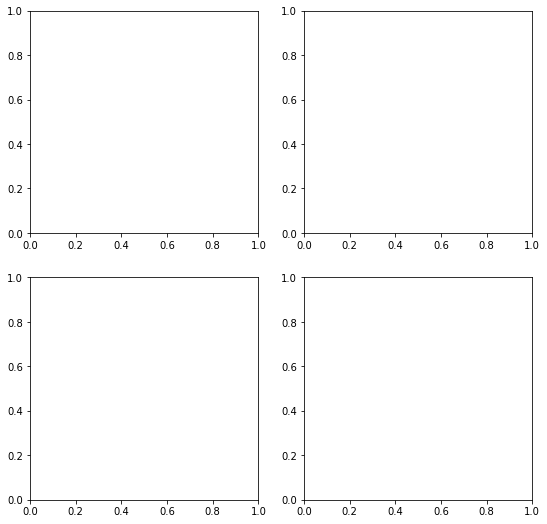

In [7]:
BuckCat_M(df)